# Cat/Dog Classifier

In [1]:
import numpy
numpy.random.seed(0)

import pandas
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from GPUtil import showUtilization as gpu_usage
from numba import cuda

CUDA_LAUNCH_BLOCKING = "1"


In [3]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  1% |  7% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 10% |  7% |


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load cat/dog image data, 
#  we resize the images for consistent model inputs.

transformation = transforms.Compose(
        [
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ]
    )

train_dataset = datasets.ImageFolder("./data/training_set/", transform=transformation)
test_dataset = datasets.ImageFolder("./data/test_set", transform=transformation)

In [6]:
# data loader
batch_size = 20

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

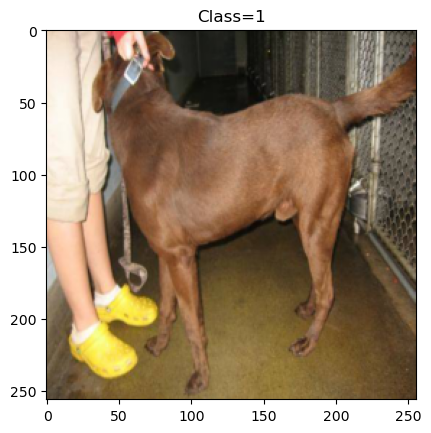

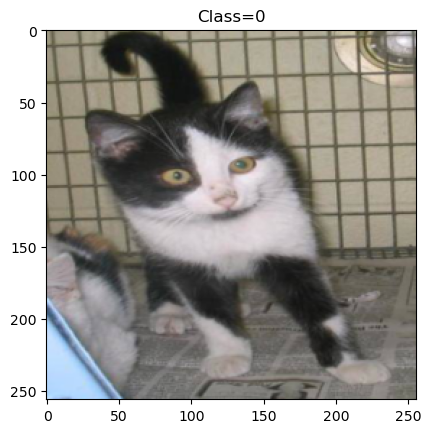

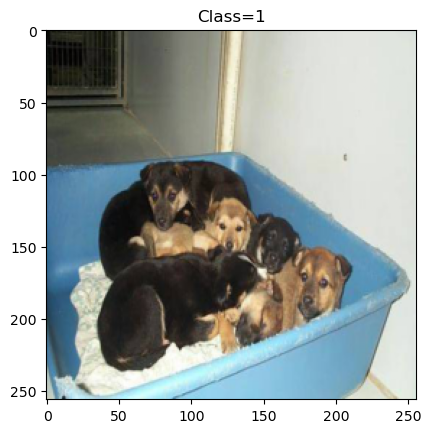

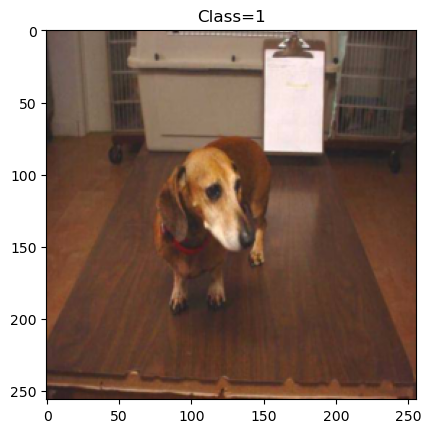

In [7]:
# quick check that the images are loaded, resized correctly and have the correct class labels.
imgs,labs = next(iter(train_loader))
for i,img in enumerate(imgs[0:4]):
    plt.figure()
    plt.title(f"Class={labs[i]}")
    plt.imshow(img.permute(1,2,0))

In [8]:
# CNN Architecture: 
#  5 convolutional layers, 
#  4 pooling layers,
#  6 fully connected layers.

class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classification_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            
            nn.Linear(512, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 2),
            nn.LeakyReLU()
        )

    def forward(self,x):
        # convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.shape[0],1,-1)
         
        # classification 
        out = self.classification_layers(out)
        out = nn.Softmax(dim=2)(out)
        return out

model = ConvNet().to(device)

In [9]:
model(imgs[0:1].to(device))

tensor([[[0.5094, 0.4906]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [10]:
# Define Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)

In [11]:
# Train the Model
num_epochs = 10

# record keeping for later plots and analytics
losses = list()
post_epoch_accuracy = list()

total_step = len(train_loader)
for epoch in range(num_epochs):

    # model training 
    for i, (images, labels) in enumerate(train_loader):

        # cuda
        images, labels = images.to(device), labels.to(device)

        # Forward Pass
        outputs = model(images).reshape(batch_size,-1)
        loss = criterion(outputs, labels)

        # Backwards and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # for plotting
        losses.append((epoch, loss.item()))

        if (i+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step[{i+1}/{total_step}]: Loss = {loss.item():.4f}")


    # model evaluation after each epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).reshape(batch_size,2)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct/total
        print(f"Test Accuracy: {(100*accuracy):.4f}%.")
        post_epoch_accuracy.append(accuracy)
    model.train()

losses = pandas.DataFrame(losses, columns=["Epoch","Loss"])

Epoch 1/10, Step[10/400]: Loss = 0.6940
Epoch 1/10, Step[20/400]: Loss = 0.6900
Epoch 1/10, Step[30/400]: Loss = 0.6920
Epoch 1/10, Step[40/400]: Loss = 0.6726
Epoch 1/10, Step[50/400]: Loss = 0.6661
Epoch 1/10, Step[60/400]: Loss = 0.6576
Epoch 1/10, Step[70/400]: Loss = 0.6449
Epoch 1/10, Step[80/400]: Loss = 0.6918
Epoch 1/10, Step[90/400]: Loss = 0.6303
Epoch 1/10, Step[100/400]: Loss = 0.6415
Epoch 1/10, Step[110/400]: Loss = 0.6619
Epoch 1/10, Step[120/400]: Loss = 0.6602
Epoch 1/10, Step[130/400]: Loss = 0.6647
Epoch 1/10, Step[140/400]: Loss = 0.6589
Epoch 1/10, Step[150/400]: Loss = 0.6186
Epoch 1/10, Step[160/400]: Loss = 0.6530
Epoch 1/10, Step[170/400]: Loss = 0.6416
Epoch 1/10, Step[180/400]: Loss = 0.6830
Epoch 1/10, Step[190/400]: Loss = 0.6672
Epoch 1/10, Step[200/400]: Loss = 0.6296
Epoch 1/10, Step[210/400]: Loss = 0.5941
Epoch 1/10, Step[220/400]: Loss = 0.6169
Epoch 1/10, Step[230/400]: Loss = 0.5758
Epoch 1/10, Step[240/400]: Loss = 0.6327
Epoch 1/10, Step[250/400]

In [ ]:
# model evaluation 
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).reshape(batch_size,2)
        _,predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct/total
    print(f"Test Accuracy: {(100*accuracy):.4f}%.")
    
model.train()

# Visualisations

Text(0.5, 1.0, 'Training Loss per Batch over 10 Epochs (with Rolling Mean over Past 400 Batches in White)')

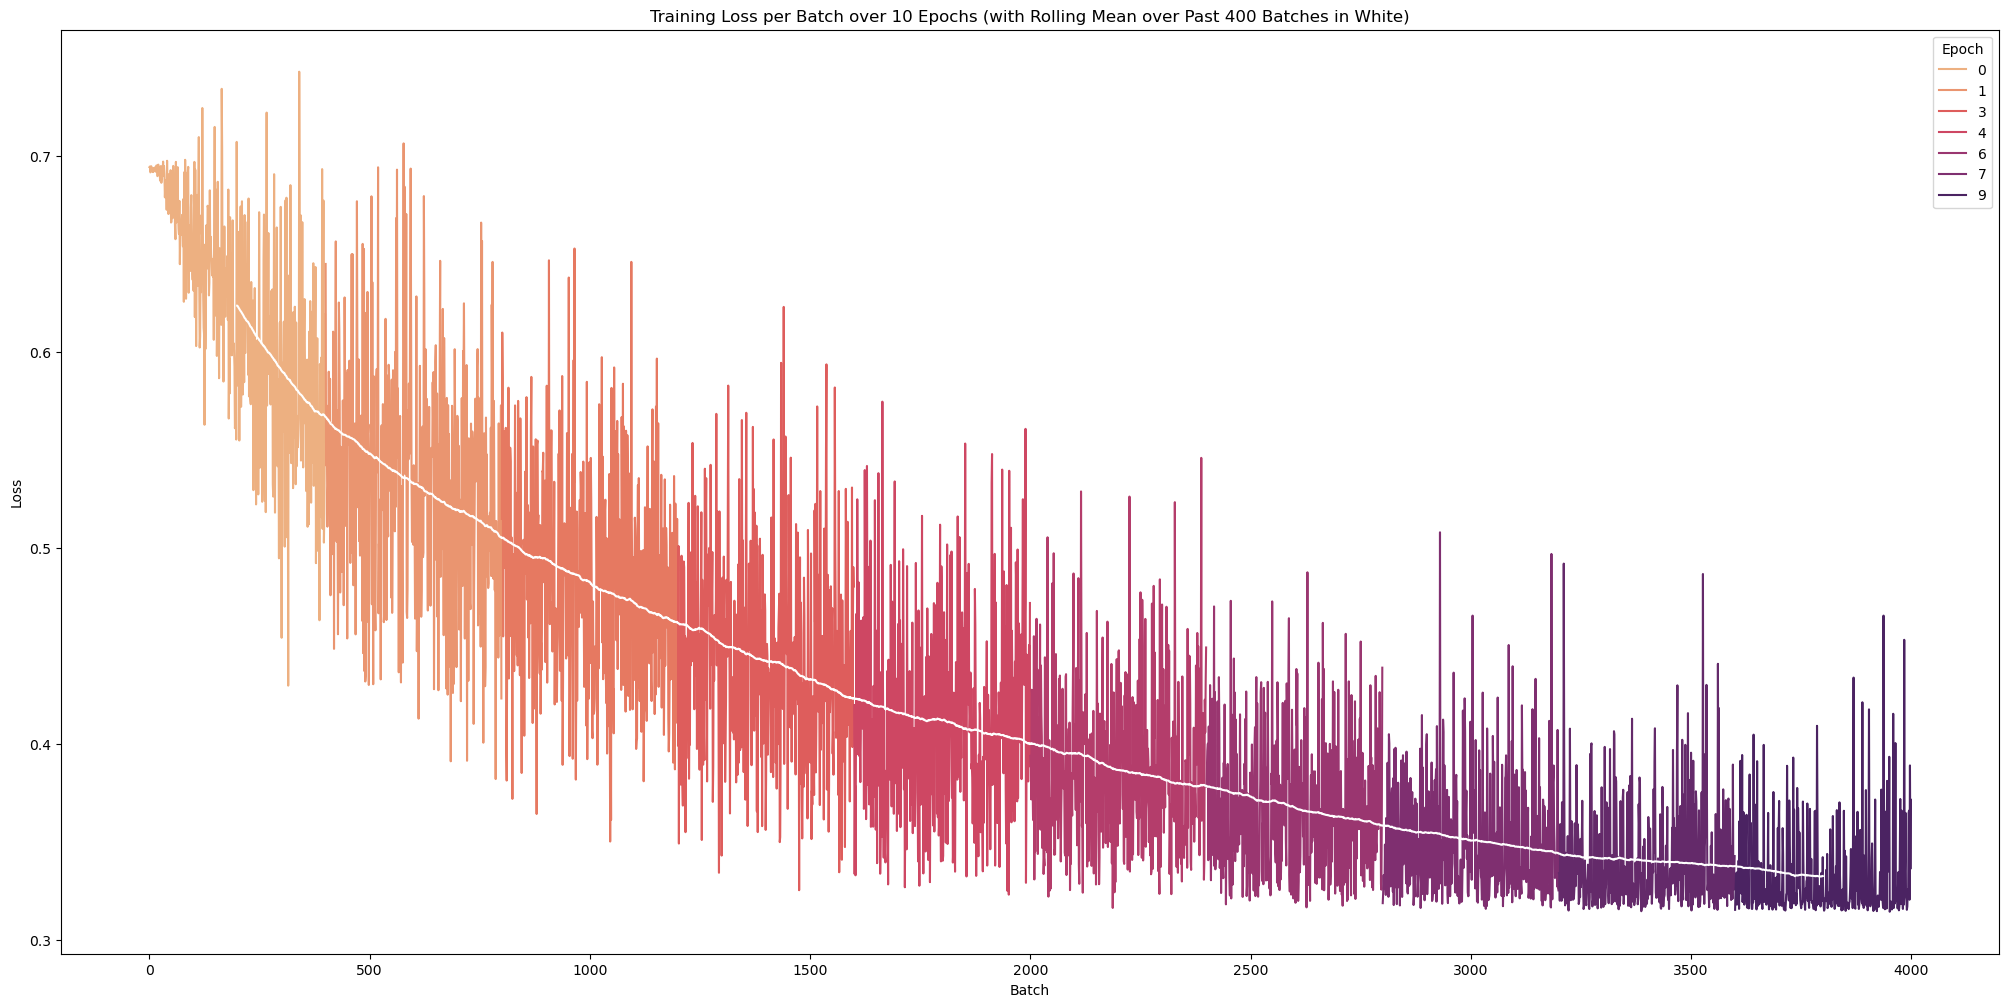

In [12]:
plt.figure(figsize=(25,12))
plt.style.use('default')
sns.lineplot(data=losses, y='Loss', x=losses.index, hue='Epoch', palette="flare")
plt.plot(losses.Loss.rolling(window=total_step).mean()[int(total_step/2):].reset_index().Loss, color="white", alpha=1)
plt.xlabel("Batch")
plt.title(f"Training Loss per Batch over {epoch+1} Epochs (with Rolling Mean over Past {total_step} Batches in White)")

plt.plot(list(range(num_epochs)), post_epoch_accuracy, color="black")

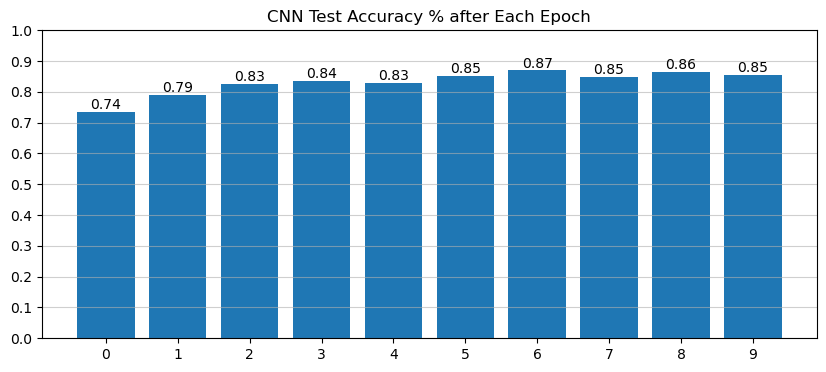

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
bars = ax.bar(list(range(num_epochs)), post_epoch_accuracy)
ax.bar_label(bars, fmt='%.2f')
plt.title("CNN Test Accuracy % after Each Epoch")
plt.xticks(list(range(num_epochs)))
plt.yticks(numpy.linspace(0,1,11))
plt.grid(axis='y', alpha=0.6)

plt.show()

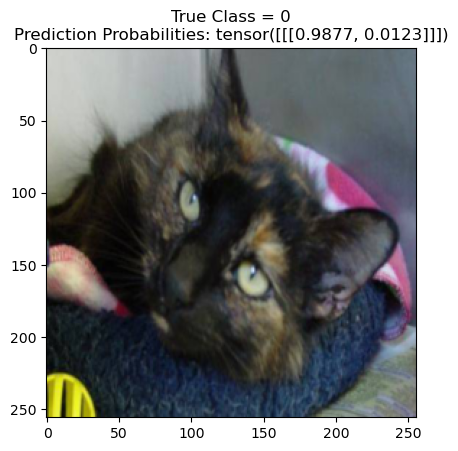

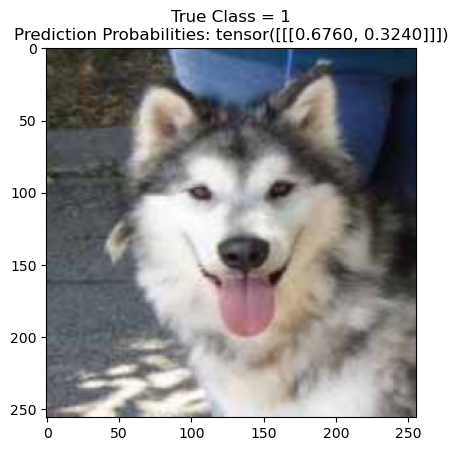

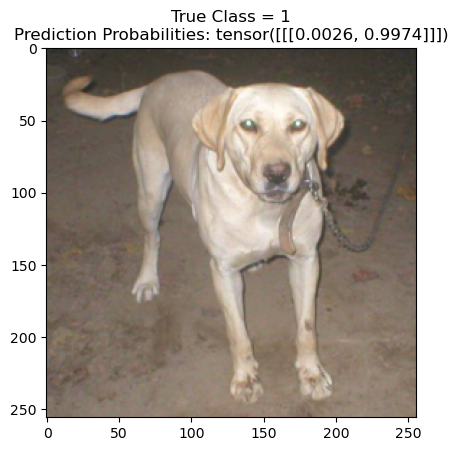

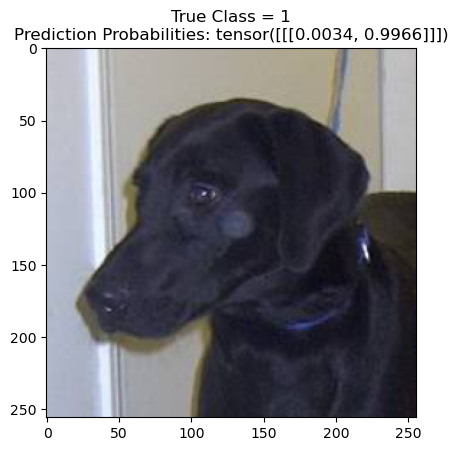

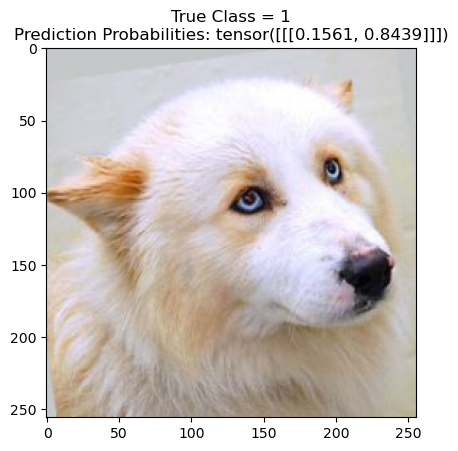

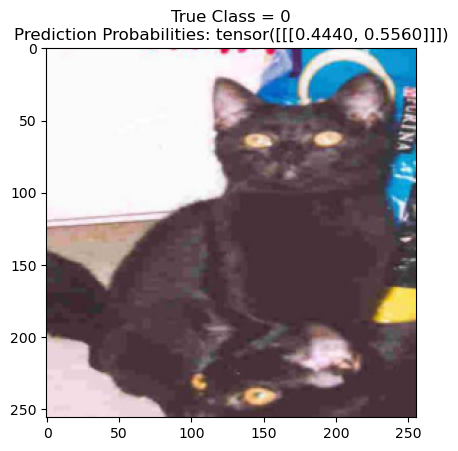

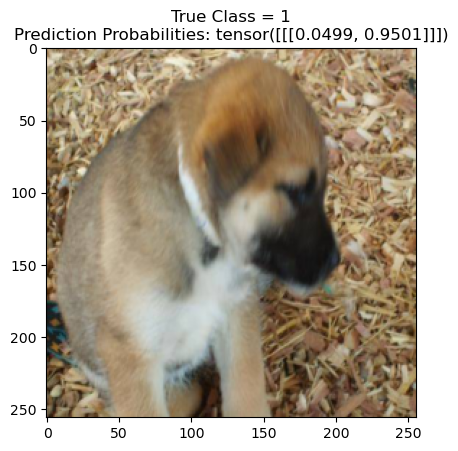

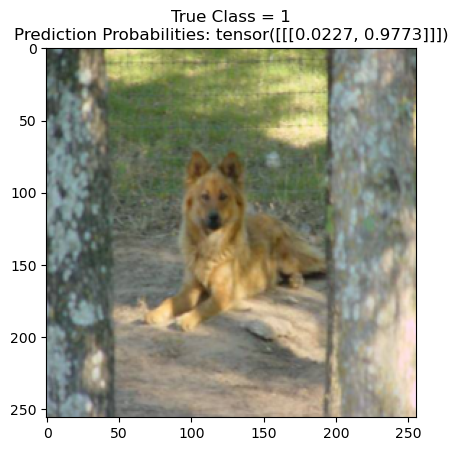

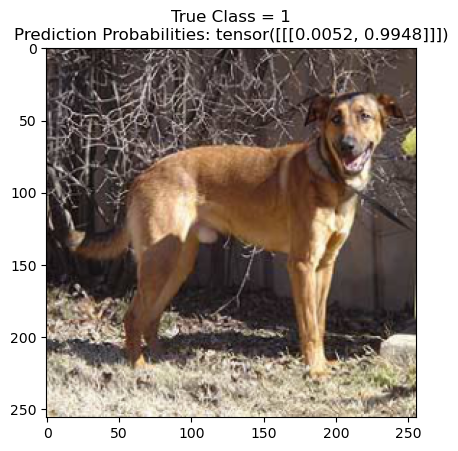

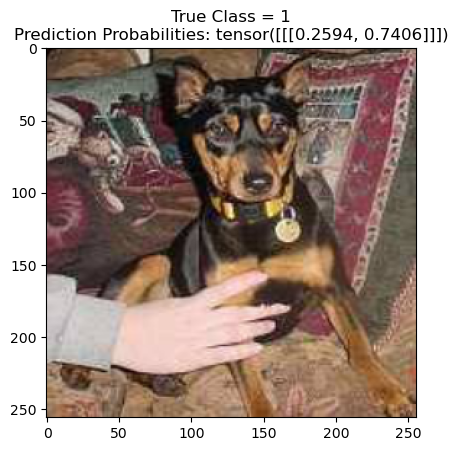

In [14]:
# Peek at predictions

for idx, pic in enumerate(images[:10].cpu()):
    plt.figure()
    plt.imshow(pic.permute(1,2,0))
    plt.title(f"True Class = {labels[idx]}\nPrediction Probabilities: {model(images[idx:(1+idx)]).detach().cpu()}")